In [ ]:
!pip install transformers sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
import os, re, string, json, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from sentence_transformers import SentenceTransformer
import faiss
import joblib

In [ ]:
CSV_PATH = "/content/hasil_scraping_TIKTOK.csv"
TEXT_COL = "content"
SCORE_COL = "score"
OUT_DIR = Path("repo_output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EMBED_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
RANDOM_SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1
N_NEIGHBORS = 5

In [ ]:
print("Loading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
assert TEXT_COL in df.columns and SCORE_COL in df.columns, "CSV harus punya kolom 'content' dan 'score'"
df = df[[TEXT_COL, SCORE_COL]].dropna().reset_index(drop=True)
print("Rows:", len(df))
print(df.head(3))

Loading CSV: /content/hasil_scraping_TIKTOK.csv
Rows: 1393
                                             content  score
0  Untuk tiktok,sangat bagus kalo kita lagi bosan...      4
1  Tik tok memang Keren dan banyak tantangan yang...      5
2  Kadang aplikasinya nge bug gabisa di buka pada...      1


In [ ]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\d+", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df[TEXT_COL].apply(clean_text)

In [ ]:
def map_score_to_sentiment(score):
    try:
        s = int(score)
    except:
        return "Netral"
    if s <= 2:
        return "Negatif"
    elif s == 3:
        return "Netral"
    else:
        return "Positif"

df["label_str"] = df[SCORE_COL].apply(map_score_to_sentiment)
print("\nLabel distribution:\n", df["label_str"].value_counts())


Label distribution:
 label_str
Negatif    737
Positif    382
Netral     274
Name: count, dtype: int64


In [ ]:
le = LabelEncoder()
y = le.fit_transform(df["label_str"])
label_names = list(le.classes_)
print("Label names:", label_names)

Label names: ['Negatif', 'Netral', 'Positif']


In [ ]:
print("\nLoading embed model:", EMBED_MODEL)
embedder = SentenceTransformer(EMBED_MODEL)
texts = df["text_clean"].tolist()

print("Computing embeddings (may take time)...")
embeddings = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True)
embeddings = embeddings.astype("float32")
print("Embeddings shape:", embeddings.shape)


Loading embed model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing embeddings (may take time)...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Embeddings shape: (1393, 384)


In [ ]:
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    embeddings, y, df.index.values, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)
# split temp -> val + test
val_count = int(len(X_temp) * (1 - VAL_SIZE))
X_val, X_test = X_temp[:val_count], X_temp[val_count:]
y_val, y_test = y_temp[:val_count], y_temp[val_count:]
idx_val, idx_test = idx_temp[:val_count], idx_temp[val_count:]

print("\nSplits:", X_train.shape[0], "train,", X_val.shape[0], "val,", X_test.shape[0], "test")


Splits: 1114 train, 251 val, 28 test


In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

clf = LogisticRegression(max_iter=2000, class_weight=class_weight_dict)
print("Training classifier...")
clf.fit(X_train, y_train)

# Save classifier + encoder
joblib.dump(clf, OUT_DIR / "clf_logreg.joblib")
joblib.dump(le, OUT_DIR / "label_encoder.joblib")
print("Saved classifier ->", OUT_DIR / "clf_logreg.joblib")

Class weights: {0: 0.6304470854555744, 1: 1.69558599695586, 2: 1.2135076252723311}
Training classifier...
Saved classifier -> repo_output/clf_logreg.joblib



Validation report:
               precision    recall  f1-score   support

     Negatif       0.70      0.70      0.70       133
      Netral       0.26      0.29      0.28        51
     Positif       0.54      0.49      0.52        67

    accuracy                           0.56       251
   macro avg       0.50      0.50      0.50       251
weighted avg       0.57      0.56      0.56       251


Test report:
               precision    recall  f1-score   support

     Negatif       0.80      0.80      0.80        15
      Netral       0.14      0.25      0.18         4
     Positif       0.83      0.56      0.67         9

    accuracy                           0.64        28
   macro avg       0.59      0.54      0.55        28
weighted avg       0.72      0.64      0.67        28



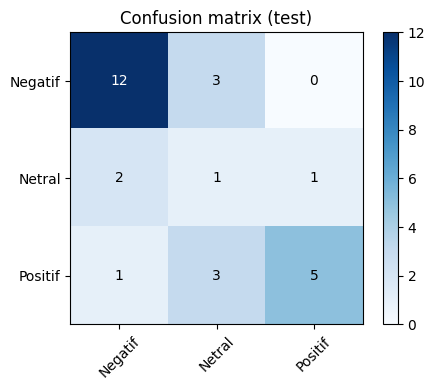

In [ ]:
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)
print("\nValidation report:\n", classification_report(y_val, y_val_pred, target_names=label_names))
print("\nTest report:\n", classification_report(y_test, y_test_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(label_names)), label_names, rotation=45)
plt.yticks(range(len(label_names)), label_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.title("Confusion matrix (test)")
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix_test.png", dpi=150)
plt.show()

In [ ]:
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

def search_similar(text, top_k=5):
    emb = embedder.encode([clean_text(text)], convert_to_numpy=True).astype("float32")
    D, I = index.search(emb, top_k)
    rows = []
    for dist, idx in zip(D[0], I[0]):
        rows.append({
            "index": int(idx),
            "text": df.loc[int(idx), TEXT_COL],
            "score": int(df.loc[int(idx), SCORE_COL]),
            "label": df.loc[int(idx), "label_str"],
            "distance": float(dist)
        })
    return rows

In [ ]:
def predict_with_probs(text):
    text_clean = clean_text(text)
    emb = embedder.encode([text_clean], convert_to_numpy=True).astype("float32")
    probs = clf.predict_proba(emb)[0]
    return {label_names[i]: float(probs[i]) for i in range(len(label_names))}

def predict_and_print(text):
    scores = predict_with_probs(text)
    top_label = max(scores, key=scores.get)
    ms = int((time.time()*1000) % 100)

    print(f"\nTulis Ulasan: {text}")
    print(f"1/1 [==============================] - 0s {ms}ms/step")
    print(f"Kalimat :  {top_label}")

    order = ["Negatif", "Netral", "Positif"]
    for lbl in order:
        val = scores.get(lbl, 0.0)
        print(f"{lbl:<7}:  {val:.7f}")

    print("\nNearest neighbors dari dataset:")
    for r in search_similar(text, top_k=3):
        print(f"- Index {r['index']}, Label: {r['label']}, Score: {r['score']}, Distance: {r['distance']:.4f}")
        print(f"  Teks: {r['text']}")
while True:
    ulasan = input("\nMasukkan ulasan (atau ketik 'exit' untuk berhenti): ")
    if ulasan.lower() == "exit":
        break
    predict_and_print(ulasan)


Masukkan ulasan (atau ketik 'exit' untuk berhenti): aplikasinya bguas banget

Tulis Ulasan: aplikasinya bguas banget
1/1 [==============================] - 0s 7ms/step
Kalimat :  Positif
Negatif:  0.0472159
Netral :  0.1675717
Positif:  0.7852124

Nearest neighbors dari dataset:
- Index 61, Label: Positif, Score: 5, Distance: 2.8333
  Teks: Memang aplikasi bagus dan mantap tapi sayang nya kalo udah di dwonload kalo udah lama kadang di link gk bisa mohon di berbaikan ya 🙏🙏🙏
- Index 287, Label: Netral, Score: 3, Distance: 3.1976
  Teks: Baguss kok, memberikan hiburan kepada kita dan ada pengetahuannya juga. Tp kak kenapa yha tiktok ku gk mau d buka😭,,,, setiap mau buka malah kembali ke laman tampilan walpeper. kadang bisa kadang engga... sampe² aku uinstal trus instal lagi.... pdhl aplikasi lain gk ada yg gitu, cuman ini aja. Ada yg sama gk??
- Index 119, Label: Negatif, Score: 1, Distance: 3.6017
  Teks: Di perbarui malah ga jelas mau buka apl nya aja kaya berat banget,. Di pencet apli